##### *Copyright 2020 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain a classification model for Edge TPU using post-training quantization (with TF2)

In this tutorial, we'll use TensorFlow 2 to create an image classification model, train it with a flowers dataset, and convert it to TensorFlow Lite using post-training quantization. Finally, we compile it for compatibility with the Edge TPU (available in [Coral devices](https://coral.ai/products/)).

The model is based on a pre-trained version of MobileNet V2. We'll start by retraining only the classification layers, reusing MobileNet's pre-trained feature extractor layers. Then we'll fine-tune the model by updating weights in some of the feature extractor layers. This type of transfer learning is much faster than training the entire model from scratch.

Once it's trained, we'll use post-training quantization to convert all parameters to int8 format, which reduces the model size and increases inferencing speed. This format is also required for compatibility on the Edge TPU.

For more information about how to create a model compatible with the Edge TPU, see the [documentation at coral.ai](https://coral.ai/docs/edgetpu/models-intro/).

**Note:** This tutorial requires TensorFlow 2.3+ for full quantization, which currently does not work for all types of models. In particular, this tutorial expects a Keras-built model and this conversion strategy currently doesn't work with models imported from a frozen graph. (If you're using TF 1.x, see [the 1.x version of this tutorial](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb).)

<a href="https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>
&nbsp;&nbsp;&nbsp;&nbsp;
<a href="https://github.com/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb" target="_parent"><img src="https://img.shields.io/static/v1?logo=GitHub&label=&color=333333&style=flat&message=View%20on%20GitHub" alt="View in GitHub"></a>


To start running all the code in this tutorial, select **Runtime > Run all** in the Colab toolbar.

## Import the required libraries

In order to quantize both the input and output tensors, we need `TFLiteConverter` APIs that are available in TensorFlow r2.3 or higher:

In [1]:
import tensorflow as tf
# assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

## Prepare the training data

First let's download and organize the flowers dataset we'll use to retrain the model (it contains 5 flower classes).

Pay attention to this part so you can reproduce it with your own images dataset. In particular, notice that the "flower_photos" directory contains an appropriately-named directory for each class. The following code randomizes and divides up the photos into training and validation sets, and generates a labels file based on the photo folder names.

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

flowers_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


228813984/228813984 [==============================] - 4s 0us/step


In [3]:
flowers_dir

'/root/.keras/datasets/flower_photos'

In [4]:
os.listdir(flowers_dir)

['sunflowers', 'tulips', 'dandelion', 'LICENSE.txt', 'daisy', 'roses']

In [5]:
!ls /root/.keras/datasets/flower_photos/sunflowers

1008566138_6927679c8a.jpg     22419079265_8902cddb7d_n.jpg  5032376020_2ed312306c.jpg
1022552002_2b93faf9e7_n.jpg   22429146402_332fa2fc72_m.jpg  5037531593_e2daf4c7f1.jpg
1022552036_67d33d5bd8_n.jpg   22429946721_e17a12cb39_n.jpg  5037790727_57c527494f.jpg
10386503264_e05387e1f7_m.jpg  22478719251_276cb094f9_n.jpg  5042785753_392cc4e74d_n.jpg
10386522775_4f8c616999_m.jpg  22686342422_c0b9e2f38e.jpg    5043404000_9bc16cb7e5_m.jpg
10386525005_fd0b7d6c55_n.jpg  22755811033_cd17b109e0.jpg    5043409092_5b12cc985a_m.jpg
10386525695_2c38fea555_n.jpg  22992257000_76dbc599e7_m.jpg  5043409856_395300dbe5_m.jpg
10386540106_1431e73086_m.jpg  2307673262_e1e1aefd29.jpg     5067864967_19928ca94c_m.jpg
10386540696_0a95ee53a8_n.jpg  23204123212_ef32fbafbe.jpg    5069564563_ae03792c3c_m.jpg
10386702973_e74a34c806_n.jpg  23247483352_0defc7a6dc_n.jpg  5076821914_c21b58fd4c_m.jpg
1043442695_4556c4c13d_n.jpg   2328600790_90e2942557_n.jpg   50987813_7484bfbcdf.jpg
1044296388_912143e1d4.jpg     23286304156_

Next, we use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset.


In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.



On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [7]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Now save the class labels to a text file:

In [8]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('flower_labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [9]:
!cat flower_labels.txt

daisy
dandelion
roses
sunflowers
tulips

## Build the model

Now we'll create a model that's capable of transfer learning on just the last fully-connected layer.

We'll start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes). This provides us a great feature extractor for image classification and we can then train a new classification layer with our flowers dataset.



### Create the base model

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [10]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


### Add a classification head

Now we create a new [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset (5 types of flowers).

In [11]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=5, activation='softmax')
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training.

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

You can see a string summary of the final network with the `summary()` method:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2626821 (10.02 MB)
Trainable params: 36883

And because the majority of the model graph is frozen in the base model, weights from only the last convolution and dense layers are trainable:

In [14]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Now we can train the model using data provided by the `train_generator` and `val_generator` that we created at the beginning.

This should take less than 10 minutes.

In [15]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 27s 340ms/step - loss: 0.6072 - accuracy: 0.7826 - val_loss: 0.4523 - val_accuracy: 0.8413
Epoch 2/10
46/46 [==============================] - 13s 280ms/step - loss: 0.2430 - accuracy: 0.9122 - val_loss: 0.4274 - val_accuracy: 0.8509
Epoch 3/10
46/46 [==============================] - 13s 283ms/step - loss: 0.1478 - accuracy: 0.9490 - val_loss: 0.4389 - val_accuracy: 0.8550
Epoch 4/10
46/46 [==============================] - 13s 280ms/step - loss: 0.0853 - accuracy: 0.9758 - val_loss: 0.4371 - val_accuracy: 0.8728
Epoch 5/10
46/46 [==============================] - 13s 275ms/step - loss: 0.0552 - accuracy: 0.9871 - val_loss: 0.5233 - val_accuracy: 0.8550
Epoch 6/10
46/46 [==============================] - 12s 271ms/step - loss: 0.0351 - accuracy: 0.9918 - val_loss: 0.4828 - val_accuracy: 0.8810
Epoch 7/10
46/46 [==============================] - 14s 296ms/step - loss: 0.0228 - accuracy: 0.9963 - val_loss: 0.5206 - val_accuracy: 0.8755

### Review the learning curves


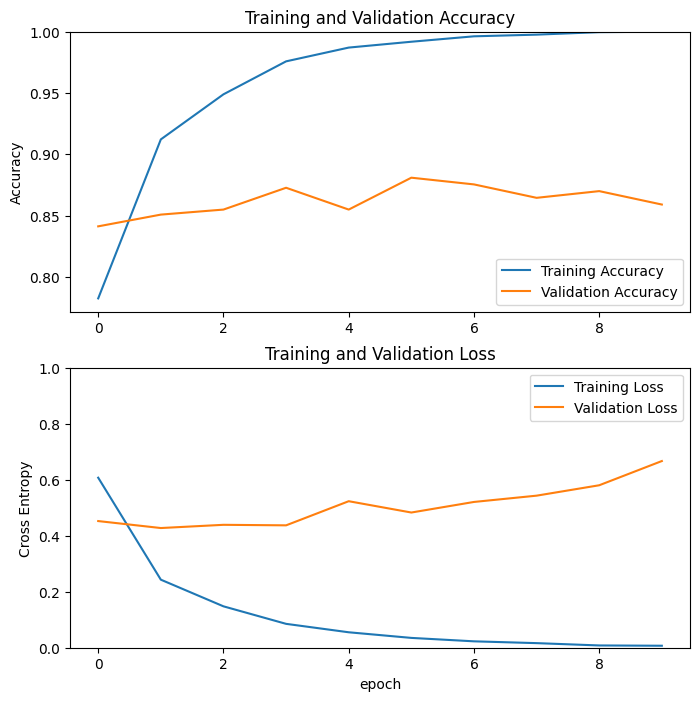

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


So far, we've only trained the classification layers—the weights of the pre-trained network were *not* changed.

One way we can increase the accuracy is to train (or "fine-tune") more layers from the pre-trained model. That is, we'll un-freeze some layers from the base model and adjust those weights (which were originally trained with 1,000 ImageNet classes) so they're better tuned for features found in our flowers dataset.

### Un-freeze more layers


So instead of freezing the entire base model, we'll freeze individual layers.

First, let's see how many layers are in the base model:

In [17]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Let's try freezing just the bottom 100 layers.

In [18]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

Now configure the model again, but this time with a lower learning rate (the default is 0.001).

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 2626821 (10.02 MB)
Trainable params: 22302

In [21]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

Now let's fine-tune all trainable layers. This starts with the weights we already trained in the classification layers, so we don't need as many epochs.

In [22]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
46/46 [==============================] - 24s 301ms/step - loss: 0.4150 - accuracy: 0.8738 - val_loss: 0.6808 - val_accuracy: 0.8687
Epoch 2/5
46/46 [==============================] - 13s 282ms/step - loss: 0.2198 - accuracy: 0.9248 - val_loss: 0.6775 - val_accuracy: 0.8687
Epoch 3/5
46/46 [==============================] - 13s 282ms/step - loss: 0.1329 - accuracy: 0.9493 - val_loss: 0.6833 - val_accuracy: 0.8700
Epoch 4/5
46/46 [==============================] - 13s 283ms/step - loss: 0.0909 - accuracy: 0.9680 - val_loss: 0.6886 - val_accuracy: 0.8687
Epoch 5/5
46/46 [==============================] - 13s 283ms/step - loss: 0.0749 - accuracy: 0.9752 - val_loss: 0.6838 - val_accuracy: 0.8632


### Review the new learning curves

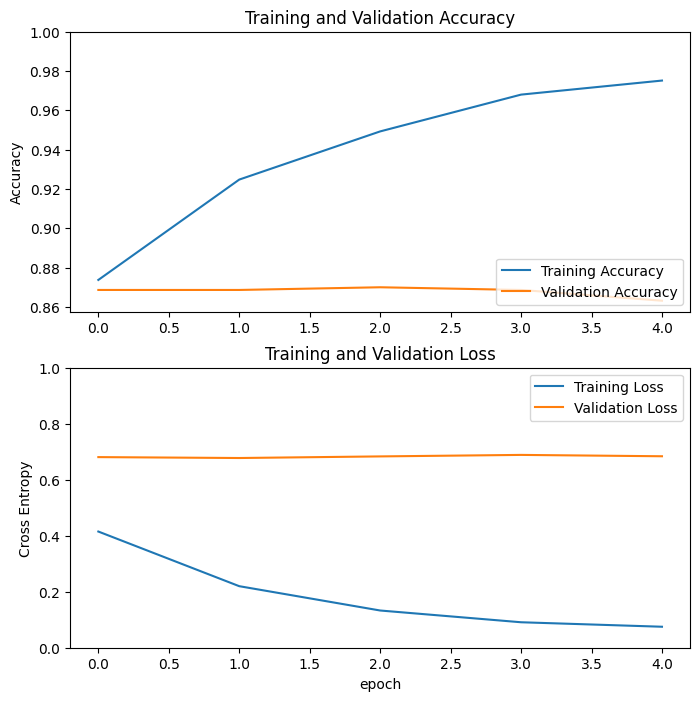

In [23]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This is better, but it's not ideal.

The validation loss is still higher than the training loss, so there could be some overfitting during training. The overfitting might also be because the new training set is relatively small with less intra-class variance, compared to the original ImageNet dataset used to train MobileNet V2.

So this model isn't trained to an accuracy that's production ready, but it works well enough as a demonstration.

Let's move on and convert the model to TensorFlow Lite.

## Convert to TFLite

Ordinarily, creating a TensorFlow Lite model is just a few lines of code with [`TFLiteConverter`](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter). For example, this creates a basic (un-quantized) TensorFlow Lite model:

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

However, this `.tflite` file still uses floating-point values for the parameter data, and we need to fully quantize the model to int8 format.

To fully quantize the model, we need to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with a representative dataset, which requires a few more arguments for the `TFLiteConverter`, and a function that builds a dataset that's representative of the training dataset.

So let's convert the model again with post-training quantization:

In [25]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(flowers_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare the accuracy


So now we have a fully quantized TensorFlow Lite model. To be sure the conversion went well, let's evaluate both the raw model and the TensorFlow Lite model.

First check the accuracy of the raw model:

In [26]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 87.500%


Now let's check the accuracy of the `.tflite` file, using the same dataset.

However, there's no convenient API to evaluate the accuracy of a TensorFlow Lite model, so this code runs several inferences and compares the predictions against ground truth:

In [27]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 87.500%


You might see some, but hopefully not very much accuracy drop between the raw model and the TensorFlow Lite model. But again, these results are not suitable for production deployment.

## Compile for the Edge TPU


Finally, we're ready to compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [28]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  24396      0 --:--:-- --:--:-- --:--:-- 24620
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [637 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4

Then compile the model:

In [29]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1157 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 2.94MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.12MiB
On-chip memory used for caching model parameters: 3.34MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


That's it.

The compiled model uses the same filename but with "_edgetpu" appended at the end.

## Download the model

You can download the converted model and labels file from Colab like this:

In [30]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('flower_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If you get a "Failed to fetch" error here, it's probably because the files weren't done saving. So just wait a moment and try again.

Also look out for a browser popup that might need approval to download the files.

## Run the model on the Edge TPU




You can now run the model on your Coral device with acceleration on the Edge TPU.

To get started, try using your `.tflite` model with [this code for image classification with the TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification).

Just follow the instructions on that page to set up your device, copy the `mobilenet_v2_1.0_224_quant_edgetpu.tflite` and `flower_labels.txt` files to your Coral Dev Board or device with a Coral Accelerator, and pass it a flower photo like this:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg
```

Check out more examples for running inference at [coral.ai/examples](https://coral.ai/examples/#code-examples/).

In [31]:
!git clone https://github.com/google-coral/pycoral.git

Cloning into 'pycoral'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 315 (delta 18), reused 13 (delta 13), pack-reused 285
Receiving objects: 100% (315/315), 6.32 MiB | 2.74 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [34]:
%cd pycoral/examples

/content/pycoral/examples


In [ ]:
!pip3 install pycoral

In [36]:
%cd ..

/content/pycoral


In [38]:
!cp examples/classify_image.py /content/pycoral

In [42]:
%cd pycoral

/content/pycoral


In [43]:
!python3 classify_image.py \
  --model /content/mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg

Traceback (most recent call last):
  File "/content/pycoral/classify_image.py", line 40, in <module>
    from pycoral.utils.edgetpu import make_interpreter
  File "/content/pycoral/pycoral/utils/edgetpu.py", line 24, in <module>
    from pycoral.pybind._pywrap_coral import GetRuntimeVersion as get_runtime_version
ModuleNotFoundError: No module named 'pycoral.pybind'


In [45]:
%cd ..

/content


In [47]:
!git clone --recurse-submodules https://github.com/google-coral/pycoral

Cloning into 'pycoral'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 315 (delta 18), reused 13 (delta 13), pack-reused 285
Receiving objects: 100% (315/315), 6.32 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Submodule 'libcoral' (https://github.com/google-coral/libcoral) registered for path 'libcoral'
Submodule 'libedgetpu' (https://github.com/google-coral/libedgetpu) registered for path 'libedgetpu'
Submodule 'test_data' (https://github.com/google-coral/test_data) registered for path 'test_data'
Cloning into '/content/pycoral/libcoral'...
remote: Enumerating objects: 409, done.        
remote: Counting objects: 100% (56/56), done.        
remote: Compressing objects: 100% (40/40), done.        
remote: Total 409 (delta 22), reused 16 (delta 16), pack-reused 353        
Receiving objects: 100% (409/409), 8.86 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (176/17

In [48]:
!pycoral/scripts/build.sh

+++ dirname pycoral/scripts/build.sh
++ cd pycoral/scripts
++ pwd
+ readonly SCRIPT_DIR=/content/pycoral/scripts
+ SCRIPT_DIR=/content/pycoral/scripts
+ readonly MAKEFILE=/content/pycoral/scripts/../Makefile
+ MAKEFILE=/content/pycoral/scripts/../Makefile
+ readonly 'DOCKER_CPUS=k8 aarch64 armv7a'
+ DOCKER_CPUS='k8 aarch64 armv7a'
+ PYTHON_VERSIONS='36 37 38 39'
+ [[ 0 -gt 0 ]]
+ for python_version in ${PYTHON_VERSIONS}
++ docker_image 36
++ case $1 in
++ echo ubuntu:18.04
+ make 'DOCKER_CPUS=k8 aarch64 armv7a' DOCKER_IMAGE=ubuntu:18.04 'DOCKER_TARGETS=pybind tflite wheel tflite-wheel' -f /content/pycoral/scripts/../Makefile docker-build
docker build  -t "coral-edgetpu-ubuntu-18.04" \
    --build-arg IMAGE=ubuntu:18.04 /content/pycoral/libcoral/docker
/bin/bash: line 1: docker: command not found
make: *** [/content/pycoral/libcoral/docker/docker.mk:31: docker-image] Error 127
